# 강화학습과 최적제어 Part 2
공정시스템 여름학교 Module C: 공정시스템을 위한 인공지능

Session 1-2: 강화학습과 최적제어

2025년 8월 20일 (수) 13:30 - 17:30

인천대학교 에너지화학공학과 김종우

In [1]:
!python -m pip install --upgrade pip
!python -m pip install "numpy<2" scipy matplotlib
!python -m pip install casadi==3.6.5
!python -m pip install torch

# 1. CSTR environment를 이용한 DQN, DDPG, A2C 구현

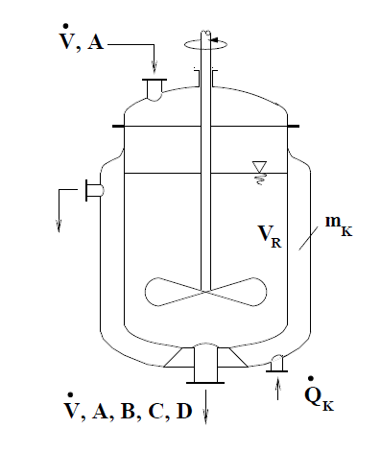

Casadi는 최적제어 분야에 유용한 DAE (differential algebraic equation) solver, NLP (nonlinear programming) solver등의 기능을 제공해주는 toolbox이다. Casadi의 integrator를 이용하여 CSTR environment를 구현할 수 있다.

다음은 $A\xrightarrow{k_1}B \xrightarrow{k_2}C$, $2A\xrightarrow{k_3}D$의 반응이 일어나는 CSTR의 그림과 모델식이다.

\begin{equation}
\begin{split}
\dot{C}_A &= \dfrac{\dot{V}}{V_R} (C_{A_0} - C_A) - k_1(T) C_A -k_3(T)C_A^2 \\
\dot{C}_B &= -\dfrac{\dot{V}}{V_R} C_B + k_1(T)C_A - k_2(T) C_B \\
\dot{T} &= \dfrac{\dot{V}}{V_R}(T_0 - T) - \dfrac{1}{\rho C_p} \left(  k_1(T)C_A\Delta H_{R_{AB}}   + k_2(T)C_B\Delta H_{R_{BC}} + k_3(T)C_A^2 \Delta H_{R_{AD}}  \right) + \dfrac{k_wA_R}{\rho C_p V_R}(T_K - T) \\
\dot{T}_K &= \dfrac{1}{m_KC_{P_K}}\left( \dot{Q}_K + k_wA_R(T - T_K) \right)
\end{split}
\end{equation}
조작변수는 $\frac{\dot{V}}{V_R}$과 $\dot{Q}_K$이고 제어변수는 $C_B$이고 setpoint는 $0.95$ (mol/L)이다.

Casadi를 이용하여 CSTR 모델을 다음과 같이 표현할 수 있다.


* `system_functions`: CSTR의 미분방정식 모델에 대해 입력 (x, u)가 주어졌을 때 (dxdt, y)를 출력
* `cost_functions`: 입력 (x, u)가 주어졌을 때, 제어 목적함수 $(y -ref)^T Q (y - ref) + u^TRu$를 출력
* `sym_expressions`: Symbolic argument (x, u)에 대해 dxdt, y, cost를 symbolic function 형태로 정의. Symbolic function을 이용하여 integrator를 정의.
* `step`: Integrator를 $(t, t+dt)$ 구간에 대해 적분하고 $t+dt$ 시점에서의 xplus, yplus, cost, episode가 종료되었는지 여부를 출력
* `scale` and `descale`: x, u, dxdt, y, cost 등의 함수가 (-1, 1) scale의 값을 갖도록 보정

In [2]:
import os
import numpy as np
import casadi as ca
import scipy as sp
import matplotlib.pyplot as plt

class CSTR(object):
    def __init__(self):
        self.env_name = 'CSTR'

        # Physio-chemical parameters for the CSTR
        self.E1 = -9758.3
        self.E2 = -9758.3
        self.E3 = -8560.
        self.rho = 0.9342  # (KG / L)
        self.Cp = 3.01  # (KJ / KG K)
        self.kw = 4032.  # (KJ / h M ^ 2 K)
        self.AR = 0.215  # (M ^ 2)
        self.VR = 10.  # L
        self.mk = 5.  # (KG)
        self.CpK = 2.0  # (KJ / KG K)
        self.CA0 = 5.1  # mol / L
        self.T0 = 378.05  # K

        self.k10 = 1.287e+12
        self.k20 = 1.287e+12
        self.k30 = 9.043e+9
        self.delHRab = 4.2  # (KJ / MOL)
        self.delHRbc = -11.0  # (KJ / MOL)
        self.delHRad = -41.85  # (KJ / MOL)

        # Dimension
        self.s_dim = 7
        self.a_dim = 2
        self.o_dim = 1

        self.t0 = 0.
        self.dt = 20 / 3600.  # hour
        self.tT = 2.  # terminal time

        self.x0 = np.array([[0., 2.1404, 1.09, 387.34, 386.06, 14.19, -1113.5]]).T
        self.u0 = np.array([[0., 0.]]).T
        self.nT = int(self.tT / self.dt)  # episode length

        self.xmin = np.array([[self.t0, 0.001, 0.5, 353.15, 363.15, 3., -9000.]]).T
        self.xmax = np.array([[self.tT, 3.5, 1.8, 413.15, 408.15, 35., 0.]]).T
        self.umin = np.array([[-0.5, -10.]]).T / self.dt
        self.umax = np.array([[0.5, 10.]]).T / self.dt
        self.ymin = self.xmin[2]
        self.ymax = self.xmax[2]

        # Basic setup for environment
        self.zero_center_scale = True
        self.set_sym_expressions()
        self.reset()

        self.plot_info = {
            'ref_idx_lst': [2],
            'state_plot_shape': (2, 3),
            'action_plot_shape': (1, 2),
            'variable_tag_lst': [
                r'Time[hour]', r'$C_{A}[mol/L]$', r'$C_{B}[mol/L]$', r'$T_{R}[^\circ C]$', r'$T_{C}[^\circ C]$',
                r'$\dot{V}/V_{R}[h^{-1}]$', r'$\dot{Q}[kJ/h]$',
                r'$\Delta\dot{V}/V_{R}[h^{-1}]$', r'$\Delta\dot{Q}[kJ/h]$'
            ]
        }

    def reset(self):
        self.time_step = 0
        x0 = self.scale(self.x0, self.xmin, self.xmax)
        u0 = self.scale(self.u0, self.umin, self.umax)
        return x0, u0

    def ref_traj(self):
        return np.array([0.95])

    def pid_gain(self):
        Kp = np.array([[-300], [100]])
        Ki = np.array([[-10], [10]])
        Kd = np.zeros((self.a_dim, self.o_dim))

        return {'Kp': Kp, 'Ki': Ki, 'Kd': Kd}

    def get_observ(self, state, action):
        observ = self.y_fnc(state, action).full()

        return observ

    def step(self, state, action):
        self.time_step += 1

        # Scaled state & action
        x = np.clip(state, -2, 2)
        u = action

        # Identify data_type
        is_term = False
        if self.time_step == self.nT:
            is_term = True

        # Integrate ODE
        res = self.I_fnc(x0=x, p=u)
        xplus = res['xf'].full()
        cost = res['qf'].full()

        return xplus, cost, is_term

    def system_functions(self, x, u):

        x = self.descale(x, self.xmin, self.xmax)
        u = self.descale(u, self.umin, self.umax)

        x = ca.fmax(x, self.xmin)
        u = ca.fmin(ca.fmax(u, self.umin), self.umax)

        k10, k20, k30, E1, E2, E3 = self.k10, self.k20, self.k30, self.E1, self.E2, self.E3
        delHRab, delHRbc, delHRad = self.delHRab, self.delHRbc, self.delHRad
        CA0, T0 = self.CA0, self.T0
        rho, Cp, kw, AR, VR = self.rho, self.Cp, self.kw, self.AR, self.VR
        mk, CpK = self.mk, self.CpK

        t, CA, CB, T, TK, VdotVR, QKdot = ca.vertsplit(x)
        dVdotVR, dQKdot = ca.vertsplit(u)

        k1 = k10 * ca.exp(E1 / T)
        k2 = k20 * ca.exp(E2 / T)
        k3 = k30 * ca.exp(E3 / T)

        dx = [1.,
              VdotVR * (CA0 - CA) - k1 * CA - k3 * CA ** 2.,
              -VdotVR * CB + k1 * CA - k2 * CB,
              VdotVR * (T0 - T) - (k1 * CA * delHRab + k2 * CB * delHRbc + k3 * CA ** 2. * delHRad) /
              (rho * Cp) + (kw * AR) / (rho * Cp * VR) * (TK - T),
              (QKdot + (kw * AR) * (T - TK)) / (mk * CpK),
              dVdotVR,
              dQKdot]

        dx = ca.vertcat(*dx)
        dx = self.scale(dx, self.xmin, self.xmax, shift=False)

        outputs = ca.vertcat(CB)
        y = self.scale(outputs, self.ymin, self.ymax, shift=True)
        return dx, y

    def cost_functions(self, x, u):

        Q = np.diag([2.])
        R = np.diag([0.01, 0.01])

        y = self.y_fnc(x, u)
        ref = self.scale(self.ref_traj(), self.ymin, self.ymax)

        cost = 0.5 * (y - ref).T @ Q @ (y - ref) + 0.5 * u.T @ R @ u
        cost /= self.dt

        return cost


    def set_sym_expressions(self):
        """Syms: :Symbolic expressions, Fncs: Symbolic input/output structures"""
        # MX variables for dae function object (no SX)
        self.state_var = ca.MX.sym('x', self.s_dim)
        self.action_var = ca.MX.sym('u', self.a_dim)

        # lists of sym_vars
        self.path_sym_args = [self.state_var, self.action_var]

        self.path_sym_args_str = ['x', 'u']

        "Symbolic functions of f, y"
        self.f_sym, self.y_sym = self.system_functions(self.state_var, self.action_var)
        self.f_fnc = ca.Function('f_fnc', [self.state_var, self.action_var], [self.f_sym], ['x', 'u'], ['f'])
        self.y_fnc = ca.Function('y_fnc', [self.state_var, self.action_var], [self.y_sym], ['x', 'u'], ['y'])

        "Symbolic function of c"
        self.c_sym = self.cost_functions(self.state_var, self.action_var)
        self.c_fnc = ca.Function('c_fnc', [self.state_var, self.action_var], [self.c_sym], ['x', 'u'], ['c'])

        "Symbolic function of dae solver"
        dae = {'x': self.state_var, 'p': self.action_var, 'ode': self.f_sym, 'quad': self.c_sym}
        opts = {'t0': 0., 'tf': self.dt}
        self.I_fnc = ca.integrator('I', 'cvodes', dae, opts)

    def scale(self, var, min, max, shift=True):
        shifting_factor = max + min if shift else 0.
        scaled_var = (2. * var - shifting_factor) / (max - min)

        return scaled_var

    def descale(self, scaled_var, min, max):
        var = (max - min) / 2 * scaled_var + (max + min) / 2

        return var

PI제어기는 다음식으로 주어진다.
\begin{equation}
u (t)= K_p(y(t) - ref) + K_i \int_0^t (y(\tau)-ref)d\tau + K_d \dfrac{dy(t)}{dt}
\end{equation}
다음 `PID` class를 통해 PID 제어기를 설계한다.


In [3]:
import numpy as np

class PID(object):
    """PID controller for generating initial warm-up data"""
    def __init__(self):
        self._a_dim = None
        self._o_dim = None
        self._dt = None

        self._Kp = None
        self._Ki = None
        self._Kd = None

        self._ref = None

    def reset(self):
        self._integral = np.zeros((self._o_dim, 1))
        self._prev_error = np.zeros((self._o_dim, 1))

    @property
    def get_info(self):
        return {'o_dim': self._o_dim, 'a_dim': self._a_dim, 'dt': self._dt}

    @get_info.setter
    def set_info(self, info):
        self._a_dim = info['a_dim']
        self._o_dim = info['o_dim']
        self._dt = info['dt']

    @property
    def get_gain(self):
        return {'Kp': self._Kp, 'Ki': self._Ki, 'Kd': self._Kd}

    @get_gain.setter
    def set_gain(self, gain):
        self._Kp = gain['Kp']
        self._Ki = gain['Ki']
        self._Kd = gain['Kd']

    @property
    def get_reference(self):
        return self._ref

    @get_reference.setter
    def set_reference(self, ref):
        self._ref = ref.reshape(self._o_dim, 1)

    def ctrl(self, observ):
        error = self._ref - observ

        proportional = error
        integral = self._integral + error * self._dt
        derivative = (error - self._prev_error) / self._dt

        action = self._Kp @ proportional + self._Ki @ integral + self._Kd @ derivative

        self._integral = integral
        self._prev_error = error

        return action

위의 PID제어기를 이용하여 `CSTR` environment의 closed-loop simulation을 수행할 수 있다.

`CSTR` class의 `pid_gain` method에 PID 제어기의 gain을 설정하였다.

`epi_path_data` 변수에 closed-loop simulation의 data tuple $(s_t, a_t, r_t, s_{t+1})$을 저장하고, 이를 `traj_data_history` 변수에 다시 분류하여 저장한다. 이때, `env.step()`의 출력값은 scaled 된 값이므로, `descale()`을 통해 실제 scale로 변환하여 저장한다.

`CSTR` class에 정의한 `plot_info` 변수를 이용하여 state, action, setpoint 등을 plot한다.

CasADi - 2025-08-20 16:12:00 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]
/tmp/ipykernel_39425/844834973.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axp.flat[fig_idx].legend()


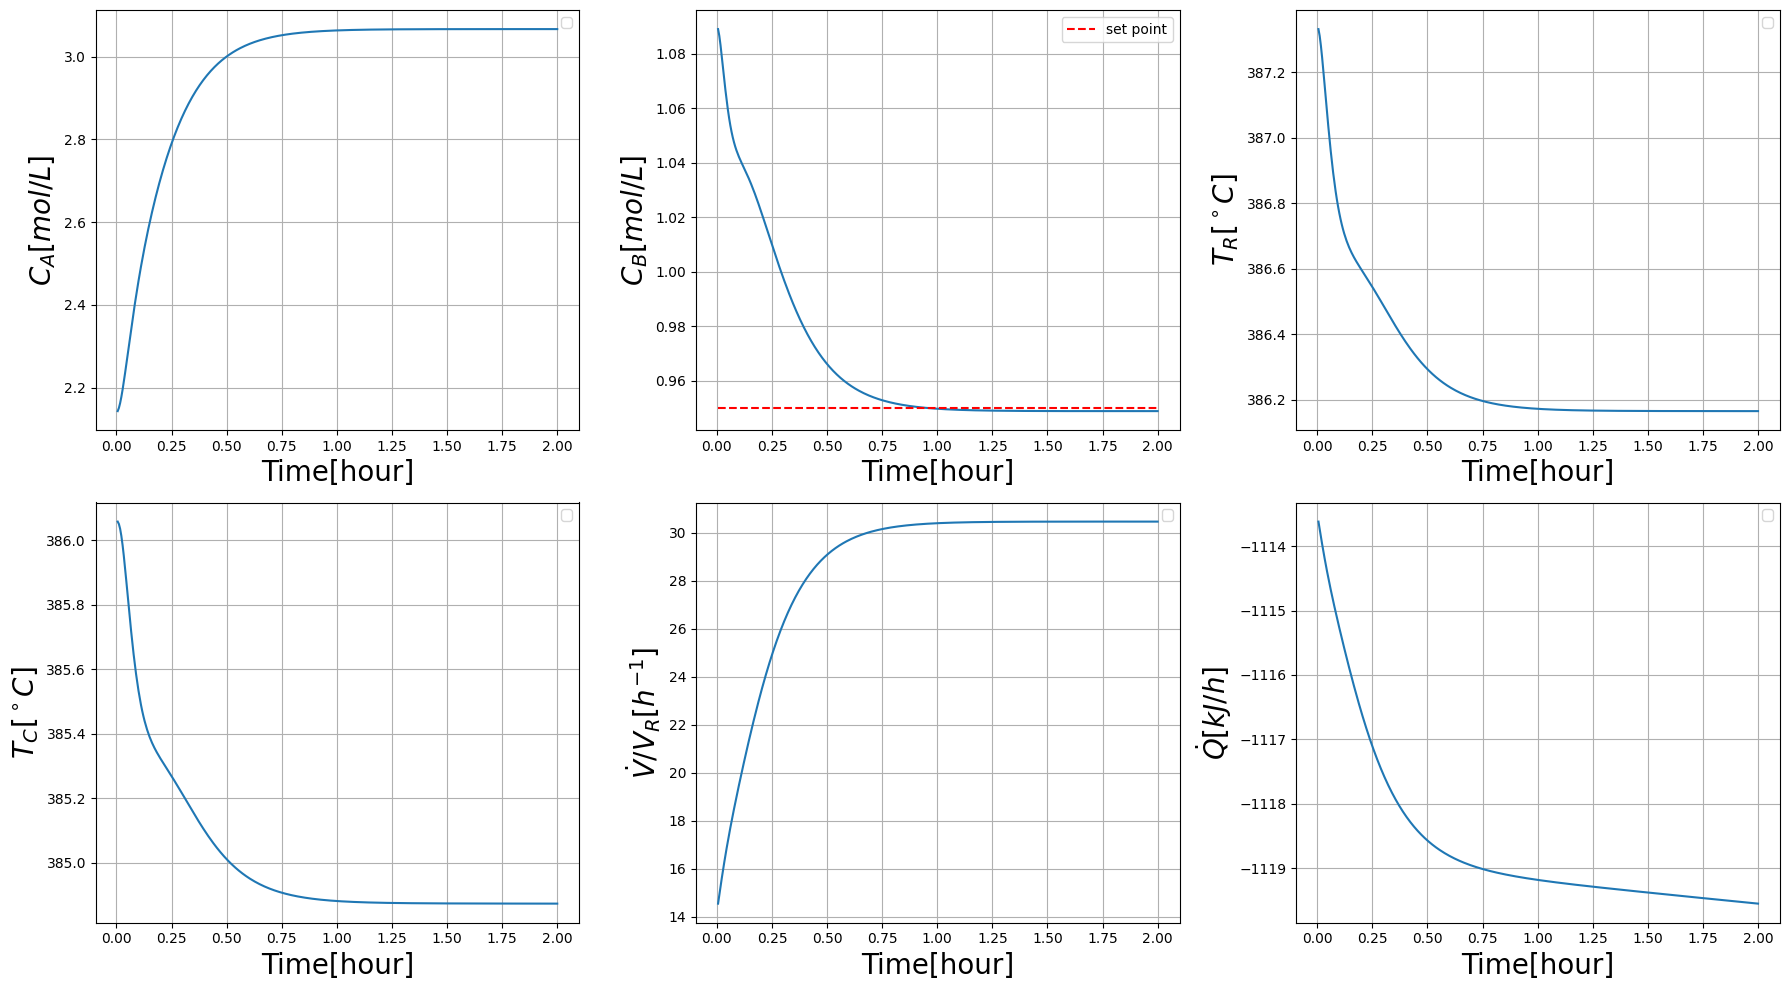

In [4]:
import numpy as np
env = CSTR()

pid = PID()
pid.set_info = {'o_dim': env.o_dim, 'a_dim': env.a_dim, 'dt': env.dt}
pid.set_gain = env.pid_gain()
pid.set_reference = env.scale(env.ref_traj(), env.ymin, env.ymax)

# Initialize
epi_path_data = []
pid.reset()
s, a = env.reset()

for step in range(env.nT):
    o = env.get_observ(s, a)
    a = pid.ctrl(o)

    a = env.scale(a, env.umin, env.umax)
    ref = env.scale(env.ref_traj(), env.ymin, env.ymax).reshape([1, -1])

    s2, r, is_term = env.step(s, a)

    s = s2

    # Save data
    epi_path_data.append([s, a, r, s2, o, ref])

# Postprocess
traj_data_history = []
for path_data in epi_path_data:
    x, u, r, x2, y2, ref = path_data

    x_record = env.descale(x, env.xmin, env.xmax).reshape([1, -1])
    y_record = env.descale(y2, env.ymin, env.ymax).reshape([1, -1])
    u_record = env.descale(u, env.umin, env.umax).reshape([1, -1])
    r_record = r.reshape([1, -1])
    ref_record = env.descale(ref, env.ymin, env.ymax).reshape([1, -1])

    temp_data_history = np.concatenate([x_record, y_record, u_record, r_record, ref_record], 1).reshape([1, -1])
    traj_data_history.append(temp_data_history)

traj_data_history = np.array(traj_data_history).reshape([env.nT, -1])

# Plot
import matplotlib.pyplot as plt

variable_tag_lst = env.plot_info['variable_tag_lst']
state_plot_idx_lst = range(1, env.s_dim)
ref_idx_lst = env.plot_info['ref_idx_lst']
nrows_s, ncols_s = env.plot_info['state_plot_shape']


figp, axp = plt.subplots(nrows=nrows_s, ncols=ncols_s, figsize=(ncols_s*6, nrows_s*5))

for fig_idx, i in enumerate(state_plot_idx_lst):

    axp.flat[fig_idx].set_xlabel(variable_tag_lst[0], fontsize=20)
    axp.flat[fig_idx].set_ylabel(variable_tag_lst[fig_idx+1], fontsize=20)

    time_grid = traj_data_history[:, 0]
    axp.flat[fig_idx].plot(time_grid, traj_data_history[:, i])
    axp.flat[fig_idx].legend()
    axp.flat[fig_idx].grid()

ref = env.ref_traj()
axp.flat[1].plot(time_grid, ref[0]*np.ones((env.nT, 1)), 'r--', label='set point')
axp.flat[1].legend()
figp.tight_layout()
plt.show()

Exploration을 위해 OU noise모델과 $\varepsilon$-greedy 모델을 사용한다.

In [5]:
import numpy as np

class OUNoise(object):
    """Ornstein-Uhlenbeck process."""
    def __init__(self, config):
        self.a_dim = config['a_dim']
        self.nT = config['nT']

        self.mu0 = 0
        self.theta = 0.15
        self.sigma = 0.2
        self.eps0 = 0.1
        self.epi_denom = 1

        self.mu = self.mu0 * np.ones([self.a_dim, 1])

        self.step = 0
        self.episode = 0
        self.exp_schedule()

    def exp_schedule(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = self.mu
        self.epsilon = self.eps0 / (1. + (self.episode / self.epi_denom))

    def sample(self, u_nom):
        """Update internal state and return it as a noise sample."""
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.a_dim, 1)
        self.state += dx
        noise = self.state * self.epsilon
        u_exp = noise + u_nom

        self.step += 1
        if self.step >= self.nT:
            self.step = 0
            self.episode += 1
            self.exp_schedule()

        return u_exp


class EpsilonGreedy(object):
    def __init__(self, config):
        self.a_dim = config['a_dim']

        n_per_dim = max(11, int(config['max_n_action_grid'] ** (1 / self.a_dim)))
        self.mesh_size = n_per_dim ** self.a_dim
        self.nT = config['nT']

        self.eps0 = 0.1
        self.epi_denom = 1

        self.step = 0
        self.episode = 0
        self.exp_schedule()

    def exp_schedule(self):
        self.epsilon = self.eps0 / (1. + (self.episode / self.epi_denom))

    def sample(self, u_nom):
        if np.random.random() <= self.epsilon:
            u_exp = np.random.randint(low=0, high=self.mesh_size, size=[1, 1])
        else:
            u_exp = u_nom

        self.step += 1
        if self.step >= self.nT:
            self.step = 0
            self.episode += 1
            self.exp_schedule()

        return u_exp

Experience data를 저장하기 위한 buffer data structure를 생성한다. Data는 $(x_t, u_t, r_t, x_{t+1}, \mathrm{done})$의 순서쌍으로 이루어져 있다.

`ReplayBuffer`는 off-policy 알고리즘 (DQN, DDPG)에서 experience data를 무작위로 sample 하기 위한 structure이다. First-in-first-out 구조로 되어있으며, 일정한 크기 (`buffer_size`)를 넘어가면 먼저 저장된 data부터 삭제한다. 다음이 이 기능을 수행한다: `self.index = (self.index + 1) % self.buffer_size`

`RolloutBuffer`는 on-policy 알고리즘 (A2C) 하나의 episode 내에 여러 step의 data를 순서대로 저장한 뒤, 학습 시 순서를 보존한 data trajectory를 통째로 sample 한다. `RolloutBuffer`는 episode가 끝날때마다 `reset()` method를 통해 buffer를 초기화한다.

- `reset()`: buffer 초기화  
- `add(experience)`: `(state, action, reward, next_state, done)` data를 현재 위치에 저장하고 index 갱신  
- `sample(use_tensor=True)`:  
  - `ReplayBuffer`: buffer에서 무작위로 `batch_size`만큼 샘플링해 반환  
  - `RolloutBuffer`: buffer 전체 데이터를 반환  


In [6]:
import abc
import torch
import numpy as np


class BaseBuffer(object, metaclass=abc.ABCMeta):
    def __init__(self, config):
        self.buffer_size = config['buffer_size']
        self.batch_size = config['batch_size']
        self.s_dim = config['s_dim']
        self.a_dim = config['a_dim']
        self.p_dim = config['p_dim']
        self.device = config['device']
        self.is_discrete_action = config['is_discrete_action']

        self.reset()

    def __len__(self):
        return self.current_size

    def reset(self):
        self.current_size = 0
        self.index = 0

        self.states = np.zeros((self.buffer_size, self.s_dim))
        if self.is_discrete_action:
            self.actions = np.zeros((self.buffer_size, 1))
        else:
            self.actions = np.zeros((self.buffer_size, self.a_dim))
        self.rewards = np.zeros((self.buffer_size, 1))
        self.next_states = np.zeros((self.buffer_size, self.s_dim))
        self.dones = np.zeros((self.buffer_size, 1))

    def add(self, experience):
        state, action, reward, next_state, done, deriv = experience

        self.states[self.index] = state.reshape(-1, )
        self.actions[self.index] = action.reshape(-1, )
        self.rewards[self.index] = reward.reshape(-1, )
        self.next_states[self.index] = next_state.reshape(-1, )
        self.dones[self.index] = done

        if self.current_size < self.buffer_size:
            self.current_size += 1
        self.index = (self.index + 1) % self.buffer_size

    @abc.abstractmethod
    def sample(self):
        pass

    def to_torch(self, array):
        return torch.tensor(array, dtype=torch.float32, device=self.device)


class ReplayBuffer(BaseBuffer):
    def __init__(self, config):
        BaseBuffer.__init__(self, config)

    def sample(self, use_tensor=True):
        batch_size = min(len(self), self.batch_size)
        indices = np.random.randint(len(self), size=batch_size)

        states = self.states[indices]
        actions= self.actions[indices]
        rewards = self.rewards[indices]
        next_states = self.next_states[indices]
        dones = self.dones[indices]
        derivs = None

        if use_tensor:
            states = self.to_torch(states)
            actions = self.to_torch(actions)
            rewards = self.to_torch(rewards)
            next_states = self.to_torch(next_states)
            dones = self.to_torch(dones)

            if self.need_derivs:
                derivs = [self.to_torch(deriv) for deriv in derivs]

        sample = {
            'states': states,
            'actions': actions,
            'rewards': rewards,
            'next_states': next_states,
            'dones': dones,
            'derivs': derivs
        }
        return sample


class RolloutBuffer(BaseBuffer):
    def __init__(self, config):
        BaseBuffer.__init__(self, config)

    def sample(self, use_tensor=True):
        states = self.states
        actions= self.actions
        rewards = self.rewards
        next_states = self.next_states
        dones = self.dones
        derivs = None

        if use_tensor:
            states = self.to_torch(states)
            actions = self.to_torch(actions)
            rewards = self.to_torch(rewards)
            next_states = self.to_torch(next_states)
            dones = self.to_torch(dones)

            if self.need_derivs:
                derivs = [self.to_torch(deriv) for deriv in derivs]

        sample = {
            'states': states,
            'actions': actions,
            'rewards': rewards,
            'next_states': next_states,
            'dones': dones,
            'derivs': derivs
        }
        return sample

Critic과 Actor는 neural networks로 구성한다.

`CriticMLP`는 (state) or (state, action) 입력을 받아 value (or Q) 함수를 출력하고, `ActorMLP`는 deterministic action 또는 Gaussian 분포 형태의 stochastic action을 생성한다. 두 네트워크 모두 MLP (multi-layer perceptron) 구조를 사용한다.

`CriticMLP` 설명
- `CriticMLP(input_dim, output_dim, hidden_dim_lst, activation_function)`
  - 입력을 MLP로 처리한 뒤 `last_fc`로 최종 출력값을 생성

`ActorMLP` 설명
- `ActorMLP(input_dim, output_dim, hidden_dim_lst, activation_function)`
  - policy head는 mean과 log_std를 각각 `last_fc_mean`, `last_fc_logstd`로 출력
  - deterministic policy의 경우 (DQN, DDPG) mean값을 action으로 사용
  - stochastic policy의 경우 (A2C) `Normal(mean, std)`에서 action 값을 샘플
  - action은 마지막에 `tanh`를 통과시켜 [-1, 1]의 값으로 변환
  - log_std는 `log_std_min`과 `log_std_max` 사이로 clip
  - `get_log_prob(state, action)`을 통해 주어진 action에 대한 log_prob를 계산
  - 이때 `distribution.log_prob(z) - log(1 - action^2 + eps)`로 log(tanh) 변환에 의한 log_prob 보정

In [7]:
import torch
import torch.nn as nn
from torch.distributions import Normal


class CriticMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim_lst, activation_function):
        super(CriticMLP, self).__init__()

        self.fc_lst = []
        current_input_dim = input_dim
        for next_input_dim in hidden_dim_lst:
            fc = nn.Linear(current_input_dim, next_input_dim)
            current_input_dim = next_input_dim
            self.fc_lst.append(fc)
        self.fc_lst = nn.ModuleList(self.fc_lst)

        self.last_fc = nn.Linear(current_input_dim, output_dim)
        self.activation_function = activation_function

    def forward(self, inputs):
        h = inputs
        for fc in self.fc_lst:
            h = self.activation_function(fc(h))
        outputs = self.last_fc(h)

        return outputs


class ActorMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim_lst, activation_function):
        super(ActorMLP, self).__init__()

        self.fc_lst = []
        current_input_dim = input_dim
        for next_input_dim in hidden_dim_lst:
            fc = nn.Linear(current_input_dim, next_input_dim)
            current_input_dim = next_input_dim
            self.fc_lst.append(fc)
        self.fc_lst = nn.ModuleList(self.fc_lst)

        self.last_fc_mean = nn.Linear(current_input_dim, output_dim)
        self.last_fc_logstd = nn.Linear(current_input_dim, output_dim)

        self.activation_function = activation_function

        self.log_std_min = -10
        self.log_std_max = 1

    def forward(self, inputs, deterministic=False, reparam_trick=True, return_log_prob=True):
        h = inputs
        for fc in self.fc_lst:
            h = self.activation_function(fc(h))

        if deterministic:
            return self._get_deterministic_action(h)
        else:
            return self._get_stochastic_action(h, reparam_trick, return_log_prob)

    def _get_deterministic_action(self, h):
        actions = torch.tanh(self.last_fc_mean(h))

        return actions

    def _get_stochastic_action(self, h, reparam_trick, return_log_prob):
        mean = self.last_fc_mean(h)
        log_std = self.last_fc_logstd(h)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)

        distribution = Normal(mean, std)
        if reparam_trick:
            z = distribution.rsample()
        else:
            z = distribution.sample()
        actions = torch.tanh(z)

        if return_log_prob:
            log_probs = distribution.log_prob(z) - torch.log(1 - actions.pow(2) + 1e-7)
        else:
            log_probs = None

        return actions, log_probs

    def get_log_prob(self, state, action):
        h = state
        for fc in self.fc_lst:
            h = self.activation_function(fc(h))

        mean = self.last_fc_mean(h)
        log_std = self.last_fc_logstd(h)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)

        distribution = Normal(mean, std)
        log_prob = distribution.log_prob(action) - torch.log(1 - action.pow(2) + 1e-7)

        return distribution, log_prob


강화학습 제어기는 class로 정의되어 있으며, 다음 함수들로 구성되어 있다.

* `ctrl(state)`: 제어 출력값을 반환하는 함수
* `add_experience`: $(x, u, r, x_2, \mathrm{done})$의 데이터 순서쌍을 buffer에 추가함.
* `train`: 사용하는 neural networks의 target 값을 계산한 후 loss function을 정의함. Gradient를 계산한 후 neural networks의 parameter를 update함.

사용하는 neural networks의 구조와 target value는 다음과 같다.

| Algorithms          | DQN | A2C   | DDPG |
|---------------------|----------------------------------------------------------------|---------------------------------------------------------|-------------------------------------------------------------|
| Net 1               | Q function ($S\rightarrow A$)        | V function ($S\rightarrow 1$)       | Q function ($S+A\rightarrow 1$)            |
| Net 2               | target Q function ($S\rightarrow A$) | policy function ($S\rightarrow 2A$) | target Q function ($S+A\rightarrow 1$)     |
| Net 3               | -                                    | -                                   | policy function ($S \rightarrow A$)        |
| Net 4               | -                                    | -                                   | target policy function ($S \rightarrow A$) |
| Critic target value | $r + \min_{u} Q(x, u)$               | $r_1 + \ldots r_n + V(x_{n+1})$     | $r + Q(x, \pi(x))$                         |
| Actor target value  |                                      | $\log\pi(u|x)A(x, u)$               | $Q(x, \pi(x))$   |
| Data buffer         |  Replay buffer | Rollout buffer | Replay buffer |


알고리즘 1: DQN (Deep Q-Network)

DQN 개요

- DQN은 Q 함수만을 사용함
- continuous state, discrete action을 사용하며, 공정제어와 같은 Continuous action space 문제를 풀 경우 action space를 discretize하여 사용
- `CriticMLP`를 이용해 Q network (state → 각 mesh action의 Q-value), $\hat{Q}_w^{\pi}$를 구현함
- 안정적인 training을 위해 target network 구조를 사용하는데, target network (`target_critic`)는 Q network의 복사본임.
- Target network의 training은 원본 network보다 의도적으로 천천히 진행함 (soft update)
- `EpsilonGreedy`로 exploration 수행. Continuous action space일 경우 가장 가까운 grid point를 사용
- `ReplayBuffer` 사용

DQN algorithm

- 초기화: replay buffer $\mathcal{D}$, Q function $\hat{Q}_w^{\pi}$, target Q function $\hat{Q}_{\tilde{w}}^{\pi}$
- For each episode
    - For each step $t=0, 1, \ldots, T-1$
        - Given $s_t$, choose $a_t = \min_a \hat{Q}_w^{\pi}(s_t, a)$  + $\epsilon$-greedy
        - Observe $r_t, s_{t+1}$
        - Store $(s_t, a_t, r_t, s_{t+1})$ to $\mathcal{D}$
        - Sample random minibatch of  $(s_i, a_i, r_i, s_{i+1})_{i=1}^n\sim \mathcal{D}$
        - Perform gradient descent step on $\sum_{i=1}^n \left[ r_i + \max_{a}\hat{Q}^{\pi}_{\tilde{w}}(s_{i+1}, a) - \hat{Q}_w^{\pi}(s_i, a_i) \right]^2$ w.r.t. $w$
        - Soft update on target critic network: $\tilde{w} \leftarrow \tau w + (1 - \tau) \tilde{w}$

주요 구성 요소
- Action mesh (`_generate_action_mesh`):  
  - 각 action dimension에 대해 `generate_non_uniform_mesh(n)`을 사용해 grid 생성
  - `np.meshgrid`로 다차원 grid를 생성하여 `a_mesh`와 총 크기 `a_mesh_dim`을 계산하고, explorer에 mesh size를 전달.  
- Control (`ctrl`):  
  - `critic(state)`를 통해 모든 mesh action의 Q-value를 계산하고, 최소 Q(비용 최소화)를 주는 index를 선택.  
  - `EpsilonGreedy.sample`로 explore 한 뒤 `_idx2action`을 통해 index를 연속 action으로 변환.
- Experience 저장 (`add_experience`):  
  - `_action2idx`로 연속 action을 mesh index로 변환하여 `(s, idx, r, s', d)` 형태로 replay buffer에 저장.  
- Training (`train`):  
  - Mini-batch를 샘플링하고 `target_critic(next_states)`로부터 target Q를 계산: $Q_{target} = r + \gamma (1-d) \min_{a'} Q_{target}(s', a')$.
  - $Q_{current}$는 `critic(states)`에서 `torch.gather`로 해당 action index 위치의 값을 추출.
  - 손실은 `MSE(current_q, target_q)`로 계산되며, optimizer로 `critic`을 업데이트하고 gradient clipping 후 `tau`로 target network를 soft update.

In [8]:
import os
import copy
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from RLcodes.network.nn import CriticMLP
from RLcodes.utility.buffer import ReplayBuffer
from RLcodes.utility.explorers import EpsilonGreedy


class DQN(object):
    def __init__(self, config):
        self.config = config
        self.device = self.config['device']
        self.s_dim = self.config['s_dim']
        self.a_dim = self.config['a_dim']
        self.nT = self.config['nT']

        # Hyperparameters
        self.num_hidden_nodes = self.config['num_hidden_nodes']
        self.num_hidden_layers = self.config['num_hidden_layers']
        hidden_dim_lst = [self.num_hidden_nodes for _ in range(self.num_hidden_layers)]

        self.gamma = self.config['gamma']
        self.critic_lr = self.config['critic_lr']
        self.adam_eps = self.config['adam_eps']
        self.l2_reg = self.config['l2_reg']
        self.grad_clip_mag = self.config['grad_clip_mag']
        self.tau = self.config['tau']
        self.max_n_action_grid = self.config['max_n_action_grid']

        self.explorer = EpsilonGreedy(config)
        self.replay_buffer = ReplayBuffer(config)

        # Action mesh
        self._generate_action_mesh()

        # Critic network (Q network)
        self.critic = CriticMLP(self.s_dim, self.a_mesh_dim, hidden_dim_lst, F.silu).to(self.device)
        self.target_critic = CriticMLP(self.s_dim, self.a_mesh_dim, hidden_dim_lst, F.silu).to(self.device)
        self.target_critic = copy.deepcopy(self.critic)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.critic_lr, eps=self.adam_eps, weight_decay=self.l2_reg)

        self.loss_lst = ['Critic loss']

    def generate_non_uniform_mesh(self, n):
        # Create a uniform grid in the interval [-1, 1]
        uniform_mesh = np.linspace(-0.999, 0.999, n)

        # Apply a non-linear transformation (e.g., tanh) to make the mesh denser near the origin
        non_uniform_mesh = np.arctanh(uniform_mesh)  # Adjust scaling factor

        non_uniform_mesh = non_uniform_mesh / np.max(np.abs(non_uniform_mesh))

        # Ensure the origin is included in the grid
        if 0 not in non_uniform_mesh:
            non_uniform_mesh = np.append(non_uniform_mesh, 0)
            non_uniform_mesh = np.sort(non_uniform_mesh)

        return non_uniform_mesh

    def _generate_action_mesh(self):
        n_per_dim = min(21, max(11, int(self.max_n_action_grid ** (1 / self.a_dim))))
        self.single_dim_mesh = self.generate_non_uniform_mesh(n_per_dim)

        # Generate action mesh and mesh index for discrete action space
        single_dim_mesh = np.array(self.single_dim_mesh)

        self.a_mesh_dim = len(single_dim_mesh) ** self.a_dim
        self.a_mesh_idx = np.arange(self.a_mesh_dim).reshape(*[len(single_dim_mesh) for _ in range(self.a_dim)])  # (M, M, .., M)
        self.a_mesh = np.stack(np.meshgrid(*[single_dim_mesh for _ in range(self.a_dim)]))  # (A, M, M, ..., M)

        self.explorer.mesh_size = self.a_mesh_dim

    def ctrl(self, state):
        with torch.no_grad():
            state = torch.tensor(state.T, dtype=torch.float32, device=self.device)
            q_values = self.critic(state)

        _, action_idx = torch.min(q_values, dim=1, keepdim=True)
        action_idx = action_idx.cpu().numpy()
        action_idx = self.explorer.sample(action_idx)
        action = self._idx2action(action_idx)

        return action

    def _idx2action(self, idx):
        if self.a_dim == 1:
            idx = idx[0]
        # Get action values from indexes
        mesh_idx = np.where(self.a_mesh_idx == idx)
        action = np.array([self.a_mesh[i][mesh_idx] for i in range(self.a_dim)])

        return action

    def add_experience(self, experience):
        state, action, reward, next_state, done, deriv = experience
        action_idx = self._action2idx(action)

        self.replay_buffer.add((state, action_idx, reward, next_state, done, deriv))

    def _action2idx(self, action):
        # Find nearest action grid values
        import math
        def find_nearest(array, value):
            idx = np.searchsorted(array, value, side="left")
            if idx > 0 and (idx == len(array) or math.fabs(value - array[idx - 1]) < math.fabs(value - array[idx])):
                return array[idx - 1]
            else:
                return array[idx]

        nrst_action_lst = [find_nearest(self.single_dim_mesh, action[i].item()) for i in range(self.a_dim)]

        # Get indexes from action values
        action2idx_lst = [self.a_mesh[i] == nrst_action_lst[i] for i in range(self.a_dim)]

        idx_lst = action2idx_lst[0]
        for i in range(1, len(action2idx_lst)):
            idx_lst = idx_lst & action2idx_lst[i]
        idx = np.where(idx_lst)
        mesh_idx = self.a_mesh_idx[idx].reshape(-1, 1)

        return mesh_idx

    def train(self):
        # Replay buffer sample
        sample = self.replay_buffer.sample()
        states = sample['states']
        action_indices = sample['actions']
        rewards = sample['rewards']
        next_states = sample['next_states']
        dones = sample['dones']

        # Compute the next Q-values using the target network
        with torch.no_grad():
            next_q = self.target_critic(next_states).detach()
            next_q, _ = torch.min(next_q, dim=1, keepdim=True)
            target_q = rewards + self.gamma * next_q * (1 - dones)

        # Get current Q-values estimates
        current_q = self.critic(states)
        current_q = torch.gather(current_q, dim=1, index=action_indices.long())

        # Get critic loss
        critic_loss = F.mse_loss(current_q, target_q)

        # Optimize the critic network
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.grad_clip_mag)
        self.critic_optimizer.step()

        # Soft update target network
        for to_model, from_model in zip(self.target_critic.parameters(), self.critic.parameters()):
            to_model.data.copy_(self.tau * from_model.data + (1 - self.tau) * to_model.data)

        loss = np.array([critic_loss.cpu().detach().numpy().item()])

        return loss



알고리즘 2: A2C (Advantage Actor-Critic)

A2C 개요

- A2C는 on-policy 방식임
- `ActorMLP`가 stochastic policy를, `CriticMLP`가 state value function을 근사함
- Gaussian 분포 형태로 Actor를 학습하므로 자연스럽게 exploration
- Episode 길이 `nT`를 저장하고 샘플하는 `RolloutBuffer`를 사용
- Critic은 MC (Monte-Carlo) return 으로 업데이트
- Actor는 advantage policy gradient으로 업데이트

A2C algorithm

- 초기화: V function $\hat{V}_w^{\pi_{\theta}}$ policy function $\hat{\pi}_{\theta}$
- For each episode
    - For each step $t=0, 1, \ldots, T-1$
        - Given $s_t$, choose $a_t \sim \hat{\pi}_{\theta}(s_t)$
        - Observe $r_t, s_{t+1}$
    - For each step $t=T-1, T-2, \ldots, 0$
        - Monte-Carlo Return estimate: $G_t \leftarrow r_t + \gamma \hat{V}_w^{\pi_{\theta}}(s_{t+1})$
        - Policy update: $\theta' \leftarrow \theta -\alpha \nabla_{\theta}\log \pi_{\theta}(a_t|s_t)(G_t - \hat{V}_w^{\pi_{\theta}}(s_{t}))$
        - Critic update: $w' \leftarrow w - \beta \dfrac{d\hat{V}_w^{\pi_{\theta}}}{dw}(G_t - \hat{V}_w^{\pi_{\theta}}(s_{t}))$

주요 구성 요소

- Policy, Value network:
  - `ActorMLP(s_dim, a_dim)`은 Gaussian policy를 출력하며, `ctrl`에서 샘플링된 action을 [-1, 1]로 clip
  - `CriticMLP(s_dim, 1)`은 state value를 출력
- RolloutBuffer:  
  - on-policy 데이터 수집을 위해 `(state, action, reward, next_state, done)` 시퀀스를 `nT` 길이로 저장
  - 한 번의 `train()` 이후 `reset()`함
- Train:
  - critic target `target values`은 Monte Carlo return을 사용
  - critic network는 `mse_loss(current_values, target_values)`를 loss function으로 하여 train
  - actor는 `advantage = target - value`에 가중치로 `log_prob`를 곱한 `(log_prob_traj * advantages).mean()`을 loss function으로 하여 train
  - log_prob은 `actor.get_log_prob(states, actions)`으로 계산

In [9]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np

from RLcodes.network.nn import ActorMLP, CriticMLP
from RLcodes.utility.buffer import RolloutBuffer


class A2C(object):
    def __init__(self, config):
        self.config = config
        self.device = self.config['device']
        self.s_dim = self.config['s_dim']
        self.a_dim = self.config['a_dim']
        self.nT = self.config['nT']

        # Hyperparameters
        self.num_hidden_nodes = self.config['num_hidden_nodes']
        self.num_hidden_layers = self.config['num_hidden_layers']
        hidden_dim_lst = [self.num_hidden_nodes for _ in range(self.num_hidden_layers)]

        self.gamma = self.config['gamma']
        self.critic_lr = self.config['critic_lr']
        self.actor_lr = self.config['actor_lr']
        self.adam_eps = self.config['adam_eps']
        self.l2_reg = self.config['l2_reg']
        self.grad_clip_mag = self.config['grad_clip_mag']

        self.use_mc_return = self.config['use_mc_return']

        config['buffer_size'] = self.nT
        config['batch_size'] = self.nT
        self.rollout_buffer = RolloutBuffer(config)

        # Critic network (State value function)
        self.critic = CriticMLP(self.s_dim, 1, hidden_dim_lst, F.silu).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.critic_lr, eps=self.adam_eps, weight_decay=self.l2_reg)

        # Actor network
        self.actor = ActorMLP(self.s_dim, self.a_dim, hidden_dim_lst, F.silu).to(self.device)
        self.actor_optimizer = optim.RMSprop(self.actor.parameters(), lr=self.actor_lr, eps=self.adam_eps, weight_decay=self.l2_reg)

        self.loss_lst = ['Critic loss', 'Actor loss']

    def ctrl(self, state):
        with torch.no_grad():
            state = torch.tensor(state.T, dtype=torch.float32, device=self.device)
            action, _ = self.actor(state, deterministic=False, reparam_trick=False, return_log_prob=False)

        action = np.clip(action.T.cpu().numpy(), -1., 1.)

        return action

    def add_experience(self, experience):
        self.rollout_buffer.add(experience)

    def train(self):
        # Replay buffer sample
        sample = self.rollout_buffer.sample()
        states = sample['states']
        actions = sample['actions']
        rewards = sample['rewards']
        next_states = sample['next_states']
        dones = sample['dones']

        # Update critic network
        if self.use_mc_return:
            # Monte Carlo (MC)
            return_values = [rewards[-1]]
            for i in range(self.nT - 1):
                return_values.append(rewards[-i-2] + self.gamma * return_values[-1])
            return_values.reverse()
            target_values = torch.stack(return_values)
        else:
            # Temporal difference (TD)
            with torch.no_grad():
                target_values = rewards + self.gamma * self.critic(next_states) * (1-dones)

        current_values = self.critic(states)
        critic_loss = F.mse_loss(current_values, target_values)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.grad_clip_mag)
        self.critic_optimizer.step()

        # Update actor network
        advantages = target_values - current_values.detach()
        _, log_prob_traj = self.actor.get_log_prob(states, actions)
        actor_loss = (log_prob_traj * advantages).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), self.grad_clip_mag)
        self.actor_optimizer.step()

        critic_loss = critic_loss.detach().cpu().item()
        actor_loss = actor_loss.detach().cpu().item()
        loss = np.array([critic_loss, actor_loss])

        # Clear replay buffer after one step train
        self.rollout_buffer.reset()

        return loss


알고리즘 3: DDPG (Deep Deterministic Policy Gradient)

DDPG 개요

- DDPG는 off-policy 방식임. 즉, behavior policy와 training policy를 다르게 사용할 수 있음
- Deterministic policy를 갖는 `ActorMLP`와 Q-function을 근사하는 `CriticMLP`(입력: [state, action])를 사용
- 데이터는 `ReplayBuffer`에 저장
- `OUNoise`로 policy 출력에 노이즈를 더해 exploration
- 안정적 학습을 위해 `target_actor`, `target_critic`을 따로 구성함. 이는 actor net과 critic net의 복사본임
- Target network는 매 스텝 `tau`로 soft update
- Behavior policy 는 원본 actor network를, training policy는 target actor network를 사용

DDPG algorithm

- 초기화: replay buffer $\mathcal{D}$, Q function $\hat{Q}_w^{\pi}$, target Q function $\hat{Q}_{\tilde{w}}^{\pi}$, policy function $\hat{\mu}_{\theta}$, target policy function $\hat{\mu}_{\tilde{\theta}}$
- For each episode
    - For each step $t=0, 1, \ldots, T-1$
        - Given $s_t$, choose $a_t =\hat{\mu}_{\theta}(s_t) + \epsilon_t$
        - Observe $r_t, s_{t+1}$
        - Store $(s_t, a_t, r_t, s_{t+1})$ to $\mathcal{D}$
        - Sample random minibatch of  $(s_i, a_i, r_i, s_{i+1})_{i=1}^n\sim \mathcal{D}$
        - Critic target: $y_i \leftarrow r_i + \hat{Q}_{\tilde{w}}^{\pi}\left(s_{i+1}, \hat{\mu}_{\tilde{\theta}}(s_{i+1})  \right) $
        - Update critic: gradient descent step on $\sum_{i=1}^n \left[ y_i - \hat{Q}_w^{\pi}(s_i, a_i) \right]^2$ w.r.t. $w$
        - Update actor: by gradient $\nabla_{\theta}J \approx \dfrac{1}{n}\sum_{i=1}^n \nabla_a \hat{Q}_w^{\pi} \nabla_{\theta}\hat{\mu}_{\theta}$
        - Soft update on target critic network: $\tilde{w} \leftarrow \tau w + (1 - \tau) \tilde{w}$
        - Soft update on target actor network: $\tilde{\theta} \leftarrow \tau \theta + (1 - \tau) \tilde{\theta}$

주요 구성 요소
- Policy and Value network:
  - `ActorMLP(s_dim, a_dim)`이 deterministic action을 출력하고, `ctrl`에서 `OUNoise.sample`로 탐험 후 [-1, 1]로 clip
  - `CriticMLP(s_dim + a_dim, 1)`은 state-action 값을 입력받아 Q-value를 출력
- ReplayBuffer:  
  - (state, action, reward, next_state, done)을 저장하고, 학습 시 무작위 minibatch 샘플
- Train:
  - critic update: `target_actor(next_states)`로 next_actions 생성 → `target_critic([next_states, next_actions])`로 `target_q = r + γ(1-d) * next_q` 계산 → `MSE(current_q, target_q)` 최소화 → gradient clipping.
  - actor update: 현재 `actor(states)`로 actor_actions 생성 → `critic([states, actor_actions])`의 평균을 최소화(= Q를 최대화하는 방향) → gradient clipping.
  - target update: actor/critic 파라미터를 `tau`로 soft update.


In [10]:
import os
import copy
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from RLcodes.network.nn import ActorMLP, CriticMLP
from RLcodes.utility.buffer import ReplayBuffer
from RLcodes.utility.explorers import OUNoise


class DDPG(object):
    def __init__(self, config):
        self.config = config
        self.device = config['device']
        self.s_dim = self.config['s_dim']
        self.a_dim = self.config['a_dim']
        self.nT = self.config['nT']

        # Hyperparameters
        self.num_hidden_nodes = self.config['num_hidden_nodes']
        self.num_hidden_layers = self.config['num_hidden_layers']
        hidden_dim_lst = [self.num_hidden_nodes for _ in range(self.num_hidden_layers)]

        self.gamma = self.config['gamma']
        self.critic_lr = self.config['critic_lr']
        self.actor_lr = self.config['actor_lr']
        self.adam_eps = self.config['adam_eps']
        self.l2_reg = self.config['l2_reg']
        self.grad_clip_mag = self.config['grad_clip_mag']
        self.tau = self.config['tau']

        self.explorer = OUNoise(config)
        self.replay_buffer = ReplayBuffer(config)

        # Critic network
        self.critic = CriticMLP(self.s_dim+self.a_dim, 1, hidden_dim_lst, F.silu).to(self.device)
        self.target_critic = CriticMLP(self.s_dim + self.a_dim, 1, hidden_dim_lst, F.silu).to(self.device)
        self.target_critic = copy.deepcopy(self.critic)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.critic_lr, eps=self.adam_eps, weight_decay=self.l2_reg)

        # Actor network
        self.actor = ActorMLP(self.s_dim, self.a_dim, hidden_dim_lst, F.silu).to(self.device)
        self.target_actor = ActorMLP(self.s_dim, self.a_dim, hidden_dim_lst, F.silu).to(self.device)
        self.target_actor = copy.deepcopy(self.actor)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.actor_lr, eps=self.adam_eps, weight_decay=self.l2_reg)

        self.loss_lst = ['Critic loss', 'Actor loss']

    def ctrl(self, state):
        with torch.no_grad():
            state = torch.tensor(state.T, dtype=torch.float32, device=self.device)
            action = self.actor(state, deterministic=True).cpu().numpy()

        action = self.explorer.sample(action.T)
        action = np.clip(action, -1., 1.)

        return action

    def add_experience(self, experience):
        self.replay_buffer.add(experience)

    def train(self):
        # Replay buffer sample
        sample = self.replay_buffer.sample()
        states = sample['states']
        actions = sample['actions']
        rewards = sample['rewards']
        next_states = sample['next_states']
        dones = sample['dones']

        # Compute the next Q values using the target values
        with torch.no_grad():
            next_actions = self.target_actor(next_states, deterministic=True)
            next_q = self.target_critic(torch.cat([next_states, next_actions], dim=-1))
            target_q = rewards + self.gamma * next_q * (1 - dones)

        # Compute critic loss & Optimize the critic networks
        current_q = self.critic(torch.cat([states, actions], dim=-1))
        critic_loss = F.mse_loss(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.grad_clip_mag)
        self.critic_optimizer.step()

        # Compute actor loss & Optimize the actor network
        actor_actions = self.actor(states, deterministic=True)
        actor_loss = self.critic(torch.cat([states, actor_actions], dim=-1)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), self.grad_clip_mag)
        self.actor_optimizer.step()

        # Soft update the target networks
        for to_model, from_model in zip(self.target_critic.parameters(), self.critic.parameters()):
            to_model.data.copy_(self.tau * from_model.data + (1 - self.tau) * to_model.data)

        for to_model, from_model in zip(self.target_actor.parameters(), self.actor.parameters()):
            to_model.data.copy_(self.tau * from_model.data + (1 - self.tau) * to_model.data)

        loss = np.array([critic_loss.detach().cpu().item(), actor_loss.detach().cpu().item()])

        return loss


Config Arguments 설명

| Argument          | Default | 설명                                 |
|-------------------|---------|------------------------------------|
| max_episode       | 20      | 최대 학습 episode 수                    |
| init_ctrl_idx     | 0       | initial controller로 training 하는 횟수 |
| buffer_size       | 1000000 | Replay buffer size                 |
| batch_size        | 1024    | minibatch size                     |
| gamma             | 0.99    | Discount factor                    |
| warm_up_episode   | 10      | warm-up episode 수                  |
| device            | 'cpu'   | 학습 및 추론 시 사용할 연산 장치                |
| num_hidden_nodes  | 128     | 각 hidden layer의 노드 수               |
| num_hidden_layers | 2       | hidden layer 개수                    |
| tau               | 0.005   | target network의 soft update 정도를 결정 |
| adam_eps          | 1e-6    | Adam optimizer epsilon 값           |
| l2_reg            | 1e-3    | L2 regularization 강도               |
| grad_clip_mag     | 5.0     | Gradient clipping 임계값              |
| critic_lr         | 1e-4 | critic network learning rate       |
| actor_lr          | 1e-4 | actor network learning rate         |



---------------------------------------
Running Environment "CSTR" with Algorithm "DDPG", Maximum episode "5"
---------------------------------------
Episode: 0 - by DDPG in CSTR
-- Cost: 0.11131211
-- Convergence Criteria: nan
-- Critic loss: 0.02744061
-- Actor loss: -33.72452954
---------------------------------------
Episode: 1 - by DDPG in CSTR
-- Cost: 0.02797175
-- Convergence Criteria: 0.00000000
-- Critic loss: 0.06597835
-- Actor loss: -28.59101439
---------------------------------------
Episode: 2 - by DDPG in CSTR
-- Cost: 0.11316113
-- Convergence Criteria: 0.01926887
-- Critic loss: 0.11842763
-- Actor loss: -20.29584354
---------------------------------------
Episode: 3 - by DDPG in CSTR
-- Cost: 0.02438509
-- Convergence Criteria: 0.03728974
-- Critic loss: 0.13555689
-- Actor loss: -5.41368996
---------------------------------------
Episode: 4 - by DDPG in CSTR
-- Cost: 0.02675680
-- Convergence Criteria: 0.04282116
-- Critic loss: 0.15153779
-- Actor loss: 11.02578670

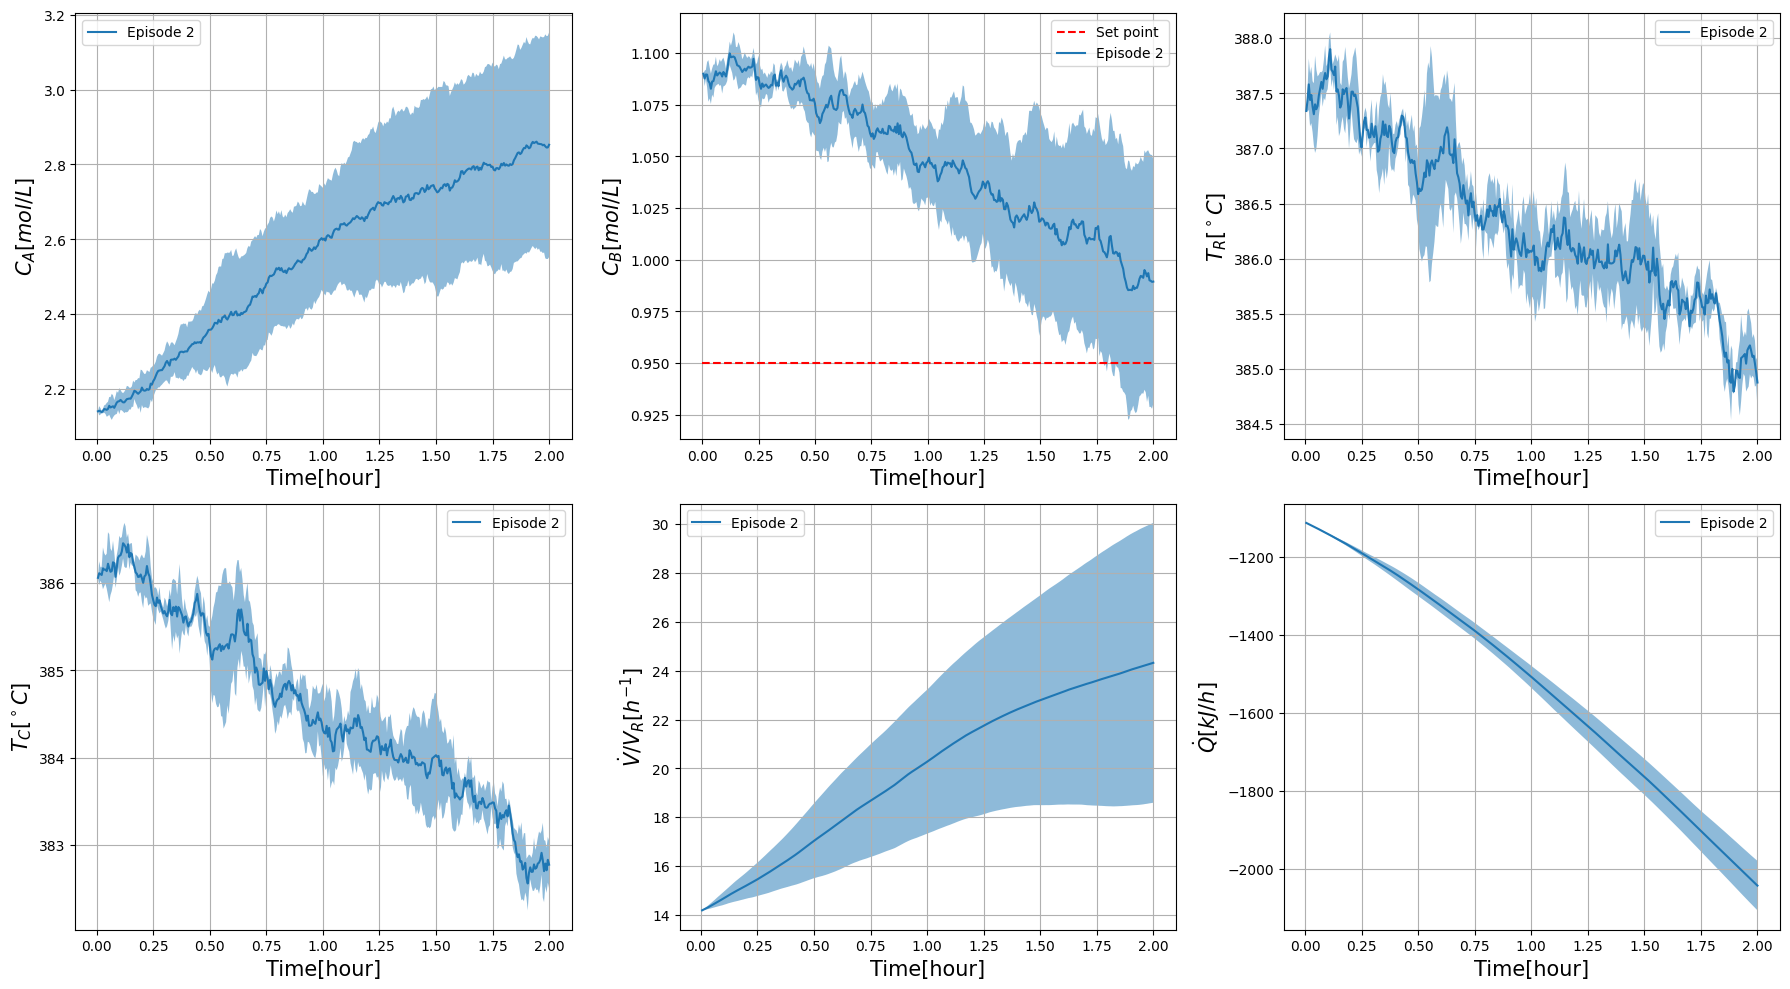

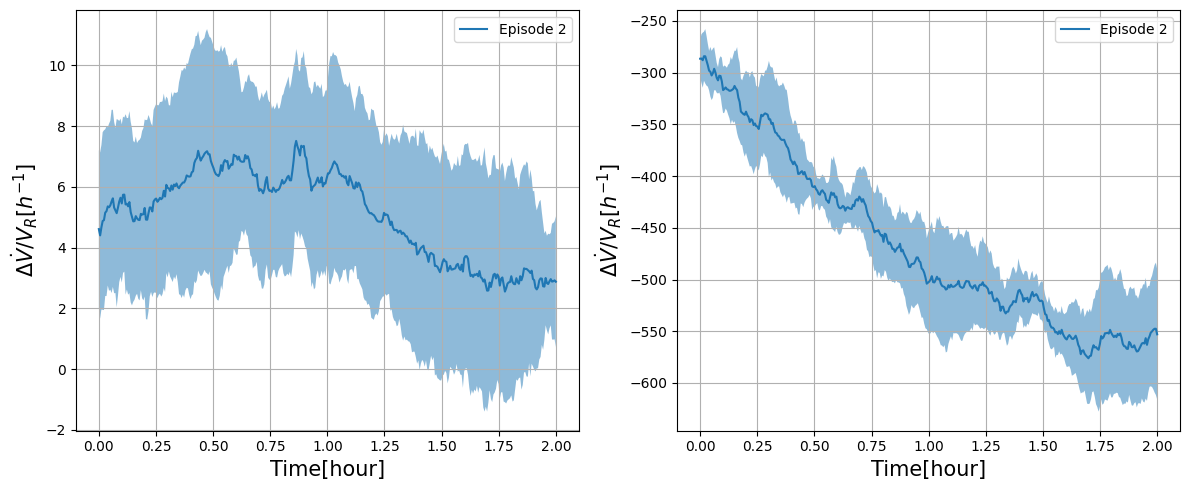

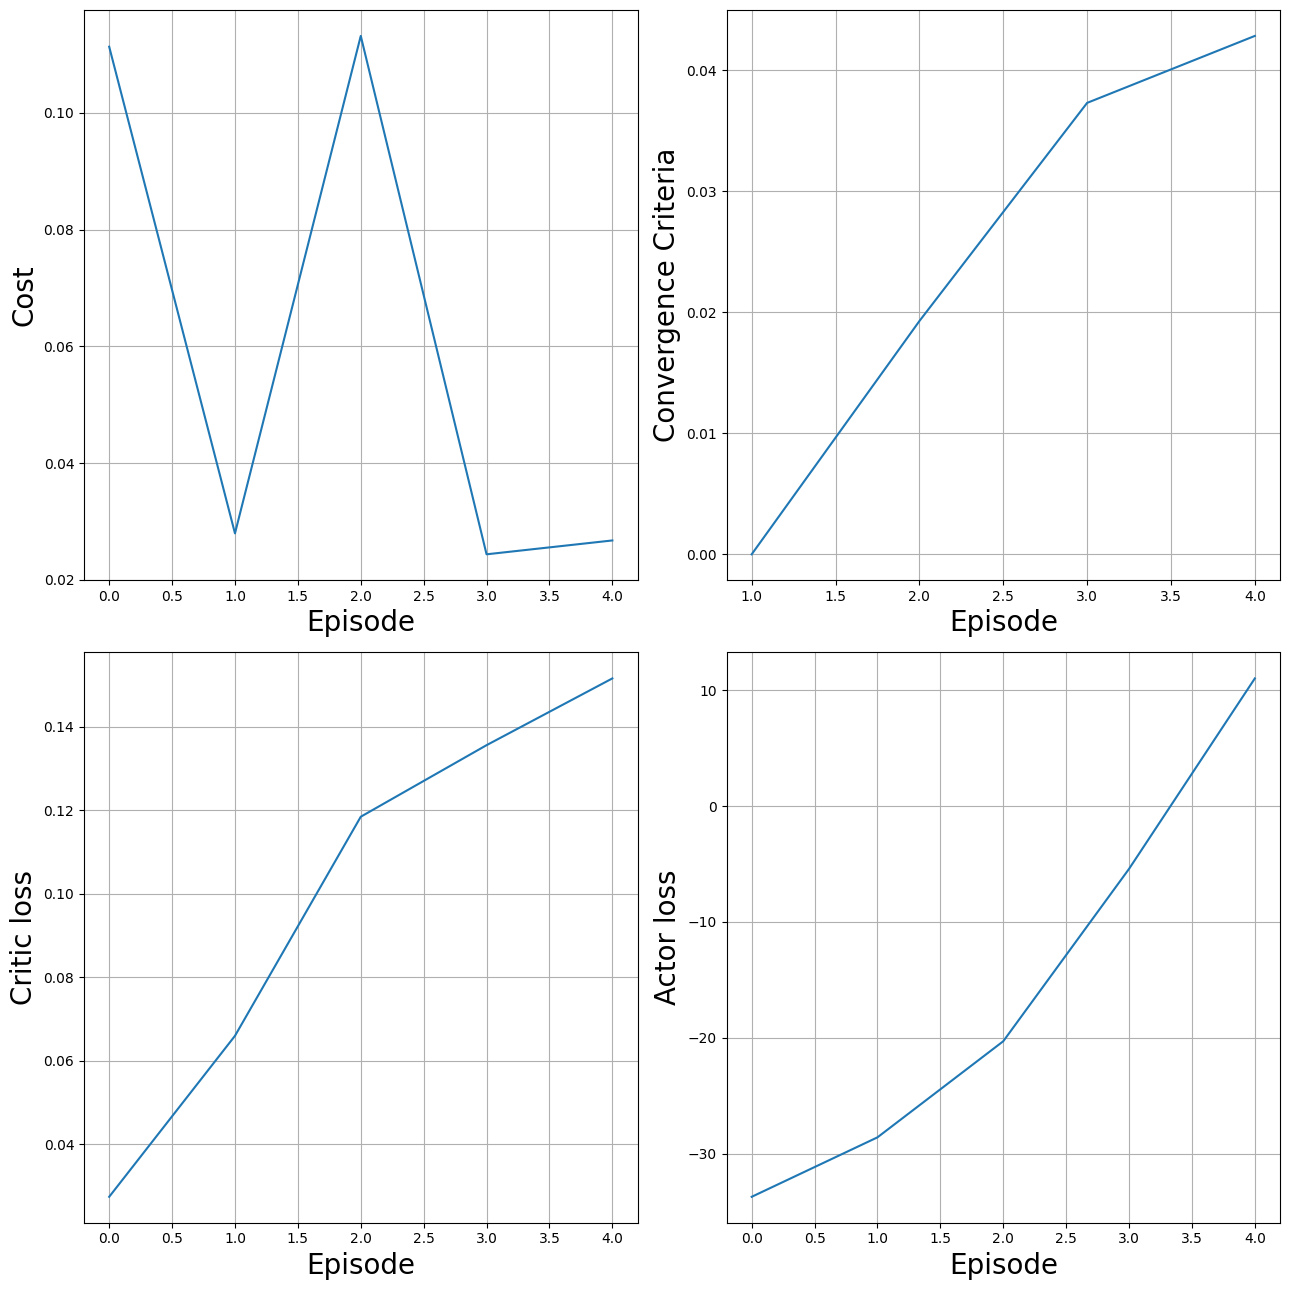

In [11]:
import os
from RLcodes.config import get_config, get_env, get_algo, set_seed
from RLcodes.train import Trainer

import sys
sys.argv = ['']

config = get_config()

# algo_name = "DQN"
algo_name = "DDPG"
# algo_name = "A2C"
config['algo'] = algo_name
config['max_episode'] = 5

env_name = config['env']
max_episode = config['max_episode']

# Set save path
config['save_path'] = os.path.join('RLcodes/result/', f'{env_name}_{algo_name}')
os.makedirs(config['save_path'], exist_ok=True)

print('---------------------------------------')
print(f'Running Environment "{env_name}" with Algorithm "{algo_name}", Maximum episode "{max_episode}"')
print('---------------------------------------')

# Set seed
set_seed(config)

# Environment
env = get_env(config)

# Algorithm
agent = get_algo(config, env)

# Train
trainer = Trainer(config, env, agent)
trainer.train()
trainer.plot()
minimum_cost = trainer.get_train_results()
